Re-analysis of the plasmodium primer rebalancing for run9

Variables:
- days 0/1/3/9 post infection - 8 individuals per point
- P1 conc: 10/20/40/80/160
- P2 conc: 10/20/40 (pools 1-5/6-10/11-15, 16 is blank
- also included are dilution series 1e4-1e8 M/P ratios,
- dilution series are repeated with coluzzii `pc` and stephensi `ps` as mosquito
- also included are other mosquito species (prefix 'A')

Results:
- infection never dissapears in the late days for P2, but sometimes does for P1
- pool 5 failed (160x P1, 10x P2)
- pools 9/10 have higher P1/P2 ratio than 14/15 suggesting that 40x P2 is too much

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
READS = '../../../data/phylo_ampl_dada2/run9/dada2/output/stats.tsv'
HAPS = '../../../data/phylo_ampl_dada2/run9/dada2/output/haplotypes.tsv'

In [3]:
reads_init = pd.read_csv(READS, sep='\t')
reads_init.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final
4819,11_9d2,26,484,478,478,478,478,478,478


In [4]:
# remove non-rebalancing samples
display(reads_init.shape)
reads_init = reads_init[~reads_init.s_Sample.str.startswith('A')]
display(reads_init.shape)

(51392, 9)

(51200, 9)

In [5]:
# mean read counts across mosquito targets
mean_mosq = reads_init[~reads_init.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mean_mosq['target'] = 'M_avg'
mean_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
772,9_3d7,190.822581,187.790323,187.483871,187.741935,185.967742,185.967742,185.919355,M_avg


In [6]:
# mean read counts across mosquito targets
sum_mosq = reads_init[~reads_init.target.str.startswith('P')].groupby('s_Sample').sum().reset_index()
sum_mosq['target'] = 'M_sum'
sum_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
305,16_0d6,7988,7904,7904,7904,7862,7862,7860,M_sum


In [7]:
# subset to plasmodium targets only
display(reads_init.shape)
reads = reads_init[reads_init.target.str.startswith('P')]
display(reads.shape)

(51200, 9)

(1600, 9)

In [8]:
# add averaged mosquito targets
display(reads.shape)
reads = pd.concat([reads, mean_mosq, sum_mosq], sort=True)
display(reads.shape)

(1600, 9)

(3200, 9)

In [9]:
# logscale input and output reads for plotting
reads['log_input'] = np.log10(reads['input'].replace(0,.1))
reads['log_final'] = np.log10(reads['final'].replace(0,.1))

In [10]:
# split out artificial mixes for separate analysis
display(reads.shape)
reads_mix = reads[reads.s_Sample.str.contains('_p')]
reads = reads[~reads.s_Sample.str.contains('_p')]
display(reads.shape)

(3200, 11)

(2560, 11)

# Dilution series analysis

In [11]:
reads_mix.head()
p = reads_mix.s_Sample.str.split('_', expand=True)
reads_mix['pool'] = p[0].astype(int)
reads_mix['mosquito_species'] = p[1].str.slice(stop=2).replace({'ps':'stephensi', 'pc':'coluzzii'})
reads_mix['conc_ratio'] = '1e-' + p[1].str.slice(start=-1)
reads_mix.sample(1)

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,log_input,log_final,pool,mosquito_species,conc_ratio
137,1331.0,1331.0,1331.0,1191.0,1351.0,1311.0,1311.0,12_ps10e4,M_sum,3.130655,3.075912,12,stephensi,1e-4


In [12]:
# primer concentrations from pools
reads_mix['P2_conc'] = ((reads_mix['pool'] - 1) // 5).replace({0:10,1:20,2:40,3:0})
reads_mix['P1_conc'] = (reads_mix['pool'] % 5).replace({1:10, 2:20, 3:40, 4:80, 0:160})
reads_mix.loc[reads_mix.pool == 16, 'P1_conc'] = 0
reads_mix.P1_conc.value_counts()

160    120
80     120
40     120
20     120
10     120
0       40
Name: P1_conc, dtype: int64

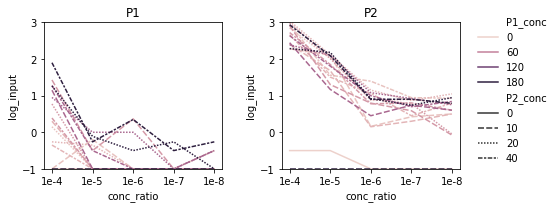

In [13]:
# dilution series
fig, axs = plt.subplots(1,2,figsize=(8, 3))
legend=None
for ax, target in zip(axs, ('P1','P2')):
    d = reads_mix.loc[reads_mix.target == target]
    g = sns.lineplot(data=d, 
             x='conc_ratio', 
             y='log_input', 
             hue='P1_conc', 
             style='P2_conc',
             ci=None, 
             ax=ax,
             legend=legend);
    legend='brief'
    ax.set_title(target)
    ax.set_ylim(-1,3)
    
plt.legend(bbox_to_anchor=(1.05, 1.1), loc=0, frameon=False);
plt.tight_layout();

# Lab infection analysis

In [14]:
# parse sequence names
def parse_sequence_names(reads):
    p = reads.s_Sample.str.split('_', expand=True)
    reads['pool'] = p[0].astype(int)
    # parse day and specimen
    di = p[1].str.split('d', expand=True)
    reads['day'] = di[0]
    reads['specimen'] = di[1]
    # handle uninfected
    u = reads['day'].str.startswith('un')
    reads.loc[u, 'specimen'] = reads.loc[u, 'day'].str.slice(start=2)
    reads.loc[u, 'day'] = reads.loc[u, 'day'].str.slice(stop=2)
    # handle pool sorting
#     sdd = reads.pool.str.len() == 1
#     reads.loc[sdd, 'pool'] = '0' + reads.loc[sdd, 'pool']
    # sampling points - combination of feed and day
#     reads['sampling_point'] = reads.feed + '_' + reads.day
#     reads['sampling_point'] = reads['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
    # parse temp and cycling
#     reads['extension_temp'] = p[3].str.slice(stop=-1) + 'C'
#     reads['cycling'] = p[3].str.get(-1).replace({'s':'subcycling','c':'standard'})
    
    return reads
reads = parse_sequence_names(reads)
reads.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,log_input,log_final,pool,day,specimen
35518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5_0d5,P1,-1.0,-1.0,5,0,5


In [15]:
reads.day.unique()

array(['0', '1', '3', '9', 'un'], dtype=object)

## Read counts

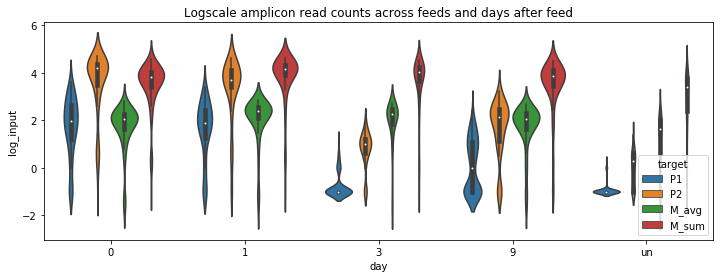

In [16]:
# total number of reads per day
fig, ax = plt.subplots(figsize=(12, 4))
sns.violinplot(data=reads, x="day", y="log_input", hue="target", ax=ax);
ax.set_title('Logscale amplicon read counts across feeds and days after feed');
# same as input reads

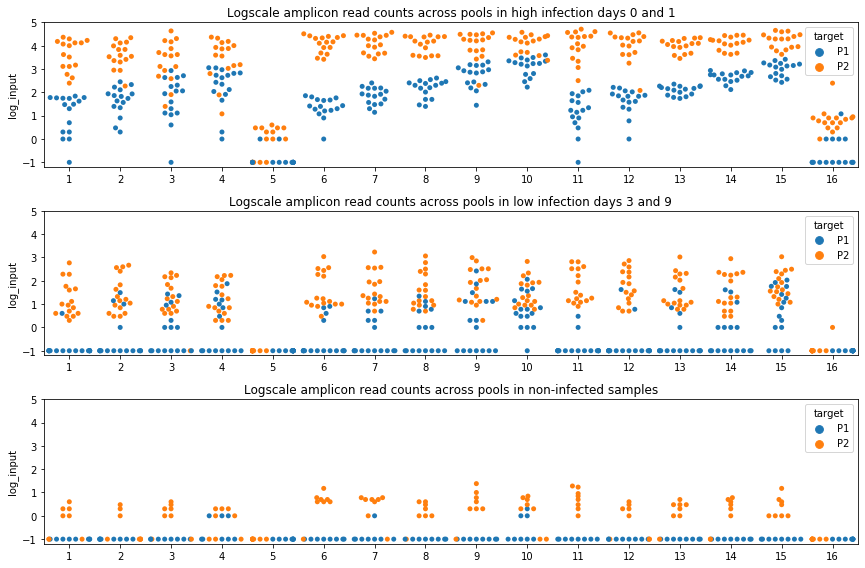

In [17]:
# pool effects on the various infection days infection days 0/1
hi_reads = reads[reads.day.isin(['0','1']) & reads.target.str.startswith('P')]
li_reads = reads[reads.day.isin(['3','9']) & reads.target.str.startswith('P')]
ni_reads = reads[(reads.day == 'un') & reads.target.str.startswith('P')]
fig, axs = plt.subplots(3,1,figsize=(12, 8))
# for pool in range(16):
#     pool = str(pool + 1)
#     d = hi_reads[hi_reads.pool==pool]
for d, legend, ax in zip([hi_reads, li_reads, ni_reads],
                         ['high infection days 0 and 1', 
                          'low infection days 3 and 9', 
                          'non-infected samples'],
                         axs):
    sns.swarmplot(data=d,
                  x='pool', y='log_input', hue='target', ax=ax);
    ax.set_title('Logscale amplicon read counts across pools in ' + legend)
    ax.set_xlabel('')
    ax.set_ylim(-1.2,5)
plt.tight_layout()

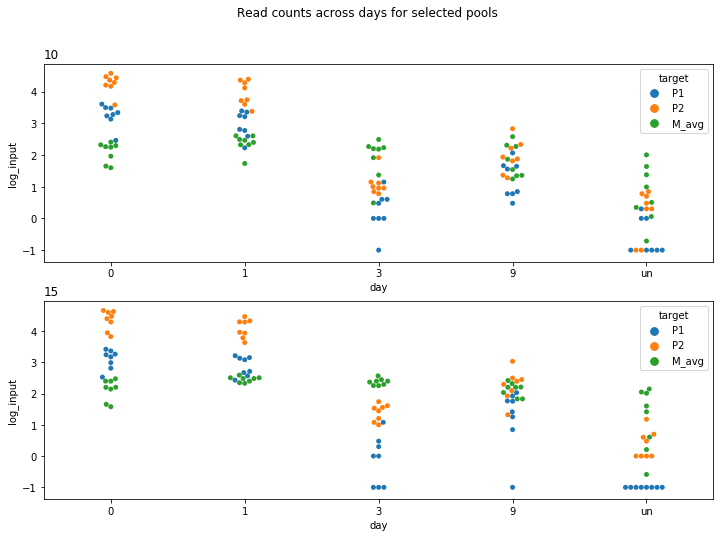

In [18]:
# swarmplots of read counts across days for selected pools
fig, axs = plt.subplots(2,1, figsize=(12, 8))
for ax, pool in zip(axs.flatten(), (10,15)):
    d = reads[(reads.pool == pool) & (reads.target != 'M_sum')]
    sns.swarmplot(data=d,
              x='day', y='log_input', hue='target', ax=ax)
    ax.set_title(str(pool), loc='left')
fig.suptitle('Read counts across days for selected pools');

## Plasmodium amplicons balance

In [19]:
pr = reads.pivot('s_Sample','target', 'input').reset_index()
pr = parse_sequence_names(pr)
pr.sample()

target,s_Sample,M_avg,M_sum,P1,P2,pool,day,specimen
224,15_9d1,208.725806,12941.0,7.0,247.0,15,9,1


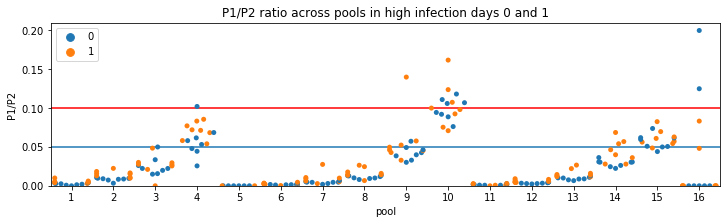

In [20]:
pr['P1/P2'] = pr.P1 / pr.P2
fig, ax = plt.subplots(figsize=(12, 3))
sns.swarmplot(data=pr[pr.day.isin(['0','1'])],
              x='pool', y='P1/P2', hue='day');

ax.axhline(.05)
ax.axhline(.1, c='r')
ax.set_ylim(0, .21)
ax.legend(loc=2)
ax.set_title('P1/P2 ratio across pools in high infection days 0 and 1');

## Read filtering effects

In [21]:
# remove dilution series
reads_init = reads_init[~reads_init.s_Sample.str.contains('_p')]
# parse sample names
reads_init = parse_sequence_names(reads_init)
# remove uninfected
reads_init = reads_init[reads_init.day != 'un']
# group targets
reads_init['tgt_group'] = reads_init.target.str.slice(0,1)
reads_init.loc[~reads_init.target.str.startswith('P'),'tgt_group'] = 'M'
#filter rate
reads_init['filter_rate'] = (reads_init.final / reads_init.input).fillna(-0.1)

reads_init.head(1)

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final,pool,day,specimen,tgt_group,filter_rate
0,10_0d1,0,377,377,377,377,377,377,377,10,0,1,M,1.0


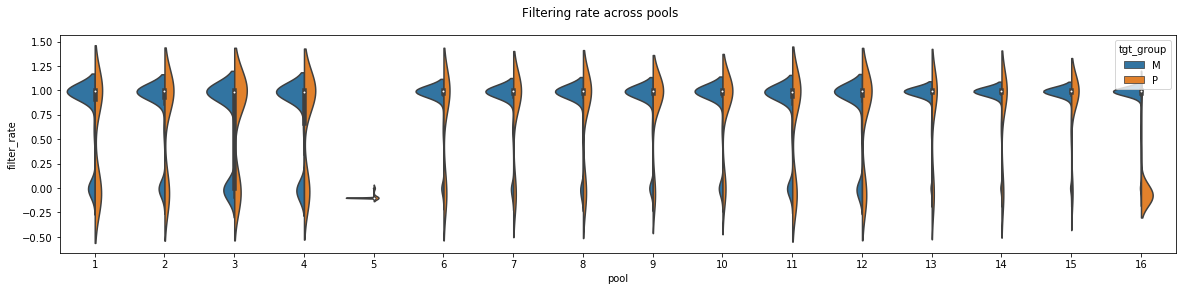

In [22]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(data=reads_init,
               x='pool',    
               y='filter_rate',
               hue='tgt_group',
               split=True,
               ax=ax)
fig.suptitle('Filtering rate across pools');
# significantly increased proportion of lost mosquito sequences in subcycling

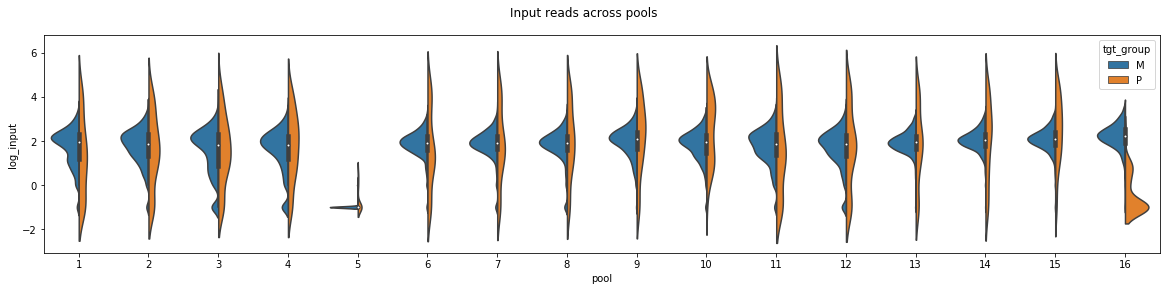

In [23]:
reads_init['log_input'] = np.log10(reads_init['input'].replace(0,0.1)).fillna(-1)
fig, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(data=reads_init,
               x='pool',    
               y='log_input',
               hue='tgt_group',
               split=True,
               ax=ax)
fig.suptitle('Input reads across pools');

In [24]:
raise Exception('analysis ended')

Exception: analysis ended

In [ ]:
reads_init.day.unique()